<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Устраняем-дисбаланс" data-toc-modified-id="Устраняем-дисбаланс-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Устраняем дисбаланс</a></span></li></ul></li><li><span><a href="#Финальное-тестирование" data-toc-modified-id="Финальное-тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Финальное тестирование</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [179]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [180]:
data.shape

(10000, 14)

In [181]:
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [182]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

В данном датасете мы видим большое количество числовых признаков. Много пропусков в столбце с данными о количестве лет,в течении которых клиент являлся клиентом банка.Пропусков в столбце Tenure около 10 процентов, заменим их на 0, чтобы они не мешали обучению. Разобъем данные на две выборки и проверим их размеры.

In [183]:
data['Tenure']= data['Tenure'].fillna(0)

In [184]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [185]:
drop_col = ['Surname', 'RowNumber', 'CustomerId']
data = data.drop(drop_col, axis=1)

In [186]:
data.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [187]:


data_train, data_test1 =train_test_split(data, test_size=0.4, random_state=12345)
data_test, data_valid=train_test_split(data_test1, test_size=0.5, random_state=12345)

features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']



In [188]:

features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']
features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']

print(features_train.shape)

print(features_valid.shape)
print(target_train.shape)
print(features_test.shape)


(6000, 10)
(2000, 10)
(6000,)
(2000, 10)


## Исследование задачи

Преобразовать категориальные признаки в численные поможет техника прямого кодирования, или отображения. Она работает со всем и моделями, поэтому будем пользоваться ей в нашем проекте. 

In [189]:


features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4,random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, test_size=0.5,random_state=12345)
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(features_test.shape)


(6000, 11)
(6000,)
(2000, 11)
(2000, 11)


In [190]:

features_train = pd.get_dummies(features_train, drop_first=True)

features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)


model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train, target_train)
#prediction = model.predict(target_valid)
# model.predict(new_item)
model.score(features_valid, target_valid)
#f1_score(target_valid,prediction)

0.7875

In [191]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000, 11)


Стандартизируем численные признаки, используя структуру StandarScaler.

In [192]:
numeric = ['CreditScore', 'Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
# scaler.fit(features_valid[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])
# < напишите код здесь >
features_test[numeric]=scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.104696,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.104696,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.503694,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.461340,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.825373,1.140475,-0.891560,0,0,1.524268,1,0,0


Обучим модель решающего дерева.
Вычислим правильность модели функцией accuracy_score(). Она принимает на вход верные ответы и предсказания, а возвращает долю правильных ответов.

In [193]:
#логистическая регрессия
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
# model.predict(new_item)

f1_score(target_valid,predicted_valid)

0.2743055555555555

Обучим модель дерева решений, подберем оптимальные параметры

In [194]:
for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth )# обучите модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучите модель
    predictions_valid = model.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print(f1_score(target_valid, predictions_valid))

max_depth = 1 : 0.0
max_depth = 2 : 0.4986301369863014
max_depth = 3 : 0.3795620437956204
max_depth = 4 : 0.48307692307692307
max_depth = 5 : 0.5015772870662459
max_depth = 6 : 0.5337423312883436
max_depth = 7 : 0.4976816074188563
max_depth = 8 : 0.4992343032159265
max_depth = 9 : 0.53781512605042
max_depth = 10 : 0.5086206896551724
max_depth = 11 : 0.49933244325767695
max_depth = 12 : 0.49343832020997375
max_depth = 13 : 0.4818652849740933
max_depth = 14 : 0.4830188679245283
max_depth = 15 : 0.4930817610062893
max_depth = 16 : 0.4975124378109453
max_depth = 17 : 0.4869565217391304
max_depth = 18 : 0.48840048840048844
max_depth = 19 : 0.4855769230769231
max_depth = 20 : 0.47664670658682634
max_depth = 21 : 0.48851269649334944
max_depth = 22 : 0.4788391777509069
max_depth = 23 : 0.4788391777509069
max_depth = 24 : 0.4788391777509069
max_depth = 25 : 0.4788391777509069
max_depth = 26 : 0.4788391777509069
max_depth = 27 : 0.4788391777509069
max_depth = 28 : 0.4788391777509069
max_depth = 

Наибольшего значения метрика f1 достигает при глубине дерева 9, она равна 0.587

In [195]:
%%time
best_model_rf = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 1):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        # обучим модель на тренировочной выборке
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model_rf = model
            best_result = result
            best_est = est
            best_depth = depth
print("F1 наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)    

F1 наилучшей модели на валидационной выборке: 0.5306748466257668 Количество деревьев: 18 Максимальная глубина: 10
CPU times: user 45.1 s, sys: 186 ms, total: 45.3 s
Wall time: 45.3 s


После обучения 3 моделей без учета дисбаланса и перебора гиперпараметров, можно прийти к выводу, что наилучший результат у дерева решений 0.587

### Устраняем дисбаланс

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

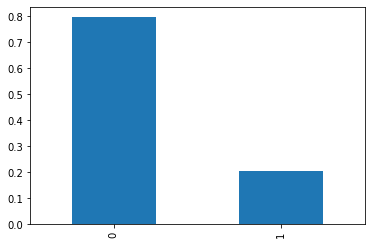

In [196]:
#соотношение классов
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Соотношение классов, как видно на графике 1:4, что говорит о дисбалансе в данных

In [216]:
#Построим матрицу ошибок для решающего дерева
confusion_matrix(target_valid, predicted_valid )

array([[1284,  293],
       [ 212,  211]])

По матрице ошибок видно, что наша модель любит истинно отрицательные ответы.
Матрица ошибок поможет построить новые метрики. Начнём с полноты (англ. recall).
Полнота выявляет, какую долю положительных среди всех ответов выделила модель. Обычно они на вес золота, и важно понимать, как хорошо модель их находит. 

In [217]:
recall_score(target_valid, predicted_valid)

0.4988179669030733

Полнота — это доля TP-ответов среди всех, у которых истинная метка 1. Хорошо, когда значение recall близко к единице: модель хорошо ищет положительные объекты. Если ближе к нулю — модель надо перепроверить и починить.
Ещё одна метрика для оценки качества прогноза целевого класса — точность.
Точность определяет, как много отрицательных ответов нашла модель, пока искала положительные. Чем больше отрицательных, тем ниже точность.

In [218]:
precision_score(target_valid, predicted_valid)

0.41865079365079366

Точность тоже не на много ближе к 1, чем полнота. Когда модель плохо предсказывает положительные классы, то мала как точность, так и полнота.Нужно обучить модель, которая, наоборот, отвечает «1» как можно реже.
Полнота и точность оценивают качество прогноза положительного класса с разных позиций. Recall описывает, как хорошо модель разобралась в особенностях этого класса и распознала его. Precision выявляет, не переусердствует ли модель, присваивая положительные метки. 
Важны обе метрики. Контролировать их параллельно помогают агрегирующие метрики, одна из которых — F1-мера (англ. F1-score). Это среднее гармоническое полноты и точности. Единица в F1 означает, что соотношение полноты и точности равно 1:1. 

In [219]:
f1_score(target_valid, predicted_valid)

0.4552319309600863

Изменим вес класса на сбалансированный и проверим как изменится метрика F1 на логистической регресии.

In [220]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4797238999137188


Произведем увеличение выборки

In [221]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1] # < напишите код здесь >
target_zeros = target_train[target_train==0]
target_ones  = target_train[target_train==1]
print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)


(4804, 11)
(1196, 11)
(4804,)
(1196,)


In [222]:
repeat = 4
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9588, 11)
(9588,)


In [223]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
model = LogisticRegression (solver = 'liblinear', random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
# < напишите код здесь >

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.43009545199326216


Произведем уменьшение выборки

In [224]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]) 
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    # < напишите код здесь >
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2397, 11)
(2397,)


In [225]:

model = LogisticRegression (solver = 'liblinear', random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
# < напишите код здесь >

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.48630136986301375


In [226]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid>threshold # < напишите код здесь >
    precision = precision_score(target_valid, predicted_valid)# < напишите код здесь >
    recall = recall_score(target_valid, predicted_valid)# < напишите код здесь >

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.00 | Точность = 0.211, Полнота = 1.000
Порог = 0.02 | Точность = 0.213, Полнота = 0.991
Порог = 0.04 | Точность = 0.225, Полнота = 0.972
Порог = 0.06 | Точность = 0.243, Полнота = 0.939
Порог = 0.08 | Точность = 0.265, Полнота = 0.920
Порог = 0.10 | Точность = 0.285, Полнота = 0.882
Порог = 0.12 | Точность = 0.302, Полнота = 0.842
Порог = 0.14 | Точность = 0.323, Полнота = 0.816
Порог = 0.16 | Точность = 0.341, Полнота = 0.759
Порог = 0.18 | Точность = 0.364, Полнота = 0.719
Порог = 0.20 | Точность = 0.371, Полнота = 0.657
Порог = 0.22 | Точность = 0.381, Полнота = 0.610
Порог = 0.24 | Точность = 0.394, Полнота = 0.574
Порог = 0.26 | Точность = 0.402, Полнота = 0.537
Порог = 0.28 | Точность = 0.419, Полнота = 0.499


Построим ROC-кривую и посчитаем AUC-ROC для логистической регрессии

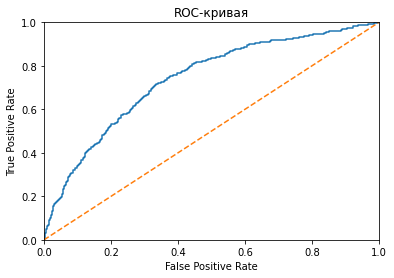

In [227]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # < напишите код здесь >

plt.figure()
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# < постройте график >
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate") 
plt.title("ROC-кривая")
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')



plt.show()

In [209]:
auc_roc = roc_auc_score(target_valid,probabilities_one_valid)
auc_roc


0.738656005132887

In [228]:


for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth )# обучите модель с заданной глубиной дерева
    model.fit(features_downsampled, target_downsampled) # обучите модель
    predictions_valid = model.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print(f1_score(target_valid, predictions_valid))

max_depth = 1 : 0.4878957169459963
max_depth = 2 : 0.5109090909090909
max_depth = 3 : 0.5261158594491927
max_depth = 4 : 0.5405857740585773
max_depth = 5 : 0.6074380165289257
max_depth = 6 : 0.5876951331496786
max_depth = 7 : 0.5426086956521738
max_depth = 8 : 0.5499999999999999
max_depth = 9 : 0.5548387096774193
max_depth = 10 : 0.5343659244917716
max_depth = 11 : 0.5238540692235734
max_depth = 12 : 0.5009009009009009
max_depth = 13 : 0.5080500894454383
max_depth = 14 : 0.49477351916376316
max_depth = 15 : 0.5101500441306267
max_depth = 16 : 0.4904347826086956
max_depth = 17 : 0.4964664310954063
max_depth = 18 : 0.49912739965095976
max_depth = 19 : 0.49128919860627185
max_depth = 20 : 0.49128919860627185
max_depth = 21 : 0.49128919860627185
max_depth = 22 : 0.49128919860627185
max_depth = 23 : 0.49128919860627185
max_depth = 24 : 0.49128919860627185
max_depth = 25 : 0.49128919860627185
max_depth = 26 : 0.49128919860627185
max_depth = 27 : 0.49128919860627185
max_depth = 28 : 0.4912891

In [229]:
%%time
best_model_rf = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 1):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        # обучим модель на тренировочной выборке
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model_rf = model
            best_result = result
            best_est = est
            best_depth = depth
print("F1 наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)    

F1 наилучшей модели на валидационной выборке: 0.5913875598086125 Количество деревьев: 11 Максимальная глубина: 10
CPU times: user 28.9 s, sys: 139 ms, total: 29 s
Wall time: 29 s


Лучший результат после балансировки данных показало дерево решений 0.5

## Финальное тестирование

In [230]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
#target_concat = pd.concat([target_train] +[target_valid]) 
#features_concat = pd.concat([features_train] +[features_valid]) 
model.fit(features_train, target_train)
                        
#model.fit(features_train, target_train)
predicted= model.predict(features_test)
"F1:", f1_score(target_test, predicted)

('F1:', 0.4888888888888888)

In [235]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6)# обучите модель с заданной глубиной дерева
model.fit(features_train, target_train) # обучите модель
predicted_test = model.predict(features_test)
    #print("max_depth =", depth, ": ", end='')
print(f1_score(target_test, predicted_test))

0.5696969696969697


In [234]:
model = RandomForestClassifier(random_state=12345, n_estimators=11, max_depth=10)
model.fit(features_train, target_train)
        # обучим модель на тренировочной выборке
predictions_test= model.predict(features_test)
f1_score(target_test, predictions_test)

0.5683890577507599

In [233]:

probabilities_test = model.predict_proba(features_test)
probabilities_one_valid = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test,probabilities_one_valid)
auc_roc


0.8463863802708702

Построена модель дерева решений с наибольшим значением метрик.